In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
from xgboost import XGBClassifier
import shap
from xgboost import plot_importance
from sklearn.metrics import roc_curve,roc_auc_score,classification_report
import warnings
warnings.simplefilter(action="ignore",category=FutureWarning)

In [2]:
#load_data
df=pd.read_csv("Loan_default.csv")

In [3]:
#sampple_data_top_2 rows
df.head(2)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0


In [4]:
# Feature Engineering

# Loan compared to income
df['LoanToIncome'] = df['LoanAmount'] / df['Income']

# Credit accounts relative to months employed (adding 1 to avoid divide by zero)
df['CreditLinesPerYearEmployed'] = df['NumCreditLines'] / (df['MonthsEmployed'] + 1)

In [5]:
# Categorizing CreditScore into bins
df['CreditScore_bin'] = pd.cut(df['CreditScore'], bins=[0,579,699,799,850], labels=['Poor','Fair','Good','Excellent'])

In [6]:
#EDA

# 1. General info about the dataset: column types, non-null counts, memory usage
print(df.info(verbose=True))

# 2. Statistical summary of numeric columns: mean, min, max, percentiles
print(df.describe())

# 3. Distribution of the target variable (Default)
print(df['Default'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   LoanID                      255347 non-null  object  
 1   Age                         255347 non-null  int64   
 2   Income                      255347 non-null  int64   
 3   LoanAmount                  255347 non-null  int64   
 4   CreditScore                 255347 non-null  int64   
 5   MonthsEmployed              255347 non-null  int64   
 6   NumCreditLines              255347 non-null  int64   
 7   InterestRate                255347 non-null  float64 
 8   LoanTerm                    255347 non-null  int64   
 9   DTIRatio                    255347 non-null  float64 
 10  Education                   255347 non-null  object  
 11  EmploymentType              255347 non-null  object  
 12  MaritalStatus               255347 non-null  object  
 13 

In [7]:
#Small_data_cleaning
#filling_missing_values
for col in df.select_dtypes(include="object").columns:
    df[col].fillna(df[col].mode()[0],inplace=True)
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(),inplace=True)

In [8]:
# Encoding categorical variables
categorical=['Education','EmploymentType', 'MaritalStatus',
       'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner','CreditScore_bin']
le=LabelEncoder()
for col in categorical:
    df[col]=le.fit_transform(df[col])


In [9]:
# drop_irrelevant_columns
df=df.drop(columns="LoanID")

In [10]:
#prepare_features_&_target
X=df.drop(columns={"Default"})
y=df["Default"]

In [11]:
#Split into train_test_sets
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [12]:
# clss imbalance needs to be handle as default is very less compared to non default
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

# Train XGBoost classifier
model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    early_stopping_rounds=50,
    use_label_encoder=False,
    random_state=42
)


scale_pos_weight: 7.61128909872692


In [13]:
# Train the model and monitor performance on validation set
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=20)

[0]	validation_0-auc:0.72486
[20]	validation_0-auc:0.74563
[40]	validation_0-auc:0.75022
[60]	validation_0-auc:0.75424
[80]	validation_0-auc:0.75633
[100]	validation_0-auc:0.75746
[120]	validation_0-auc:0.75820
[140]	validation_0-auc:0.75854
[160]	validation_0-auc:0.75877
[180]	validation_0-auc:0.75870
[200]	validation_0-auc:0.75865
[213]	validation_0-auc:0.75854


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,'auc'


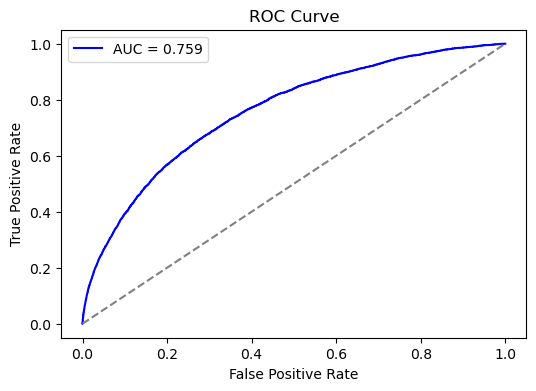

In [14]:


# Predict the probability of default for the validation set
y_pred_prob = model.predict_proba(X_val)[:,1]

# Computing ROC curve and AUC
fpr, tpr,_ = roc_curve(y_val, y_pred_prob)
auc_score = roc_auc_score(y_val, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [ ]:
# SHAP feature importance to explain model predictions
explainer = shap.Explainer(model)
shap_values = explainer(X_val)

# Visualize feature impact on model predictions
shap.summary_plot(shap_values, X_val)

In [ ]:
#feature_importance_using_xgboost
plot_importance(model,importance_type='weight')
plt.show()

In [ ]:
# Convert predicted probabilities to class labels (0 or 1)
y_pred_class = (y_pred_prob >= 0.5).astype(int)

# Evaluate model performance using precision, recall, f1-score
print(classification_report(y_val, y_pred_class))
